In [105]:
from strym import strymread
from strym import strymmap
# import numpy as np

import strym
print(strym.__version__)

0.4.11


In [106]:
folder = '/Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/'
file_choser = ['2021-08-02-01-14-34_2T3W1RFVXMW116290',
               '2021-08-02-11-05-12_2T3W1RFVXMW116290',
               '2021-08-02-12-03-21_2T3W1RFVXMW116290',
               '2021-08-02-14-22-46_2T3W1RFVXMW116290',
               '2021-08-02-14-34-31_2T3W1RFVXMW116290',
               '2021-08-02-15-25-10_2T3W1RFVXMW116290',]
index = 1
# NOTE: le 1 semble être rempli et pas mal
file = file_choser[index]
canfile = folder + file + '_CAN_Messages.csv'
gpsfile = folder + file + '_GPS_Messages.csv'


def read_metadata(canfile, gpsfile):
    """
    :param canfile: string, csv file
    :param gpsfile: string, csv file
    :return: strymreads of can and gps files, dictionnary of the meta-datas associated
    TODO: find how to extract the metadata here (maybe from strymread)?
      Find also the desired metadata to be logged into the DB
      -> what could be the useful thing to sort on? car model? day? other things?
    """

    # read canfile
    s = strymread(csvfile=canfile)
    print(f'reading of {canfile} was succesful? {s.success}')

    # read and link gpsfile
    g = strymmap(csvfile=gpsfile)
    print(f'reading of {gpsfile} was succesful? {g.success}')

    return s, g, {}


def read_data(can, gps):
    """
    :param can: strymread object
    :param gps: strymmap object
    :return: speed, lead_distance, cruise_control time series
    """
    speed_ts = can.speed()
    lead_distance_ts = can.lead_distance()
    cruise_control_state_ts = can.acc_state()
    return speed_ts, lead_distance_ts, cruise_control_state_ts


# def find_crossing_old(speed, lead_distance, cruise_control_state, with_cruise_control: bool = True, speed_treshold = 20,
#                   prev_treshold = 10, next_treshold = 5, verbose: bool = False):
#     """
#     finds the time where car crossing events happens, from ts associated to 1 specific acquisition
#     NOTE: choice of the default value:
#         - about 5 meters for a vehicle size --> immediately dangerous if a vehicle comes closer than this: go from 10 to 5
#         - 20 m/s is approximately highway speeds of 45MPH --> treshold speed to see dangerous crossings at high speeds
#     :param speed: Time Series of the speed
#     :param lead_distance: Time Series of the Speed
#     :param cruise_control_state: Time Series of the Controller state (=6 if activated)
#     :param with_cruise_control: boolean. Defaults to True. Turn to False to also return car crossing events if the cruise_control is disabled
#     :param speed_treshold:
#     :param prev_treshold: minimum lead distance before the crossing to consider the event as a car crossing
#     :param next_treshold: maximum lead distance after the crossing to consider the car crossing as dangerous
#     :param verbose: Set to true to get more logs
#     :return: array<time>, of event_times of car crossing events
#     TODO: find how to define time with the time series
#     TODO: find time format with the time series? Is there a preferred one? seems that yes with a clock
#     TODO: refine the cruise control state to also encompass other semi-activated states as if controller on?
#     """
#     kmh_speed_treshold = speed_treshold * 3.6
#     event_times = []
#
#     # TODO: find which TS use to extract time? are they the same?
#     time_list = lead_distance['Time']
#
#     lead_distance_list = lead_distance['Message']
#     speed_list = speed['Message']
#     print(len(speed_list), len(lead_distance_list), len(time_list))
#     ts_length = min(len(speed_list), len(lead_distance_list), len(time_list))
#     if with_cruise_control:
#         cruise_control_state_list = cruise_control_state['Message']
#         ts_length = min(ts_length, len(cruise_control_state_list))
#     else:
#         cruise_control_state_list = None
#
#     # NOTE: starting on second data point to be able to read the preceeding one
#     # Here the tests on the data are made at each data point
#     for i in range(1, ts_length):
#         if verbose:
#             print('\n', 'index is : ', i)
#             if with_cruise_control:
#                 print('cruise_control_state : ', cruise_control_state_list[i])
#             print('lead_distance : ', lead_distance_list[i])
#             print('speed : ', speed_list[i])
#
#         t_speed = (speed_list[i] >= kmh_speed_treshold)
#         t_lead_distance = (lead_distance_list[i - 1] >= prev_treshold) and (lead_distance_list[i] >= next_treshold)
#         if with_cruise_control:
#             t_state = (cruise_control_state_list[i] == 6)
#         else:
#             t_state = True
#
#         if verbose:
#             print('test speed : ', t_speed)
#             print('test lead_distance : ', t_lead_distance)
#             if with_cruise_control:
#                 print('test state : ', t_state)
#
#         if t_speed and t_lead_distance and t_state:
#             event_times.append({'time': time_list[i], 'index': i})
#
#     return event_times


def find_crossing(speed, lead_distance, cruise_control_state, with_cruise_control: bool = True, speed_treshold = 20,
                  prev_treshold = 10, next_treshold = 5, verbose: bool = False):
    """
    finds the time where car crossing events happens, from ts associated to 1 specific acquisition
    NOTE: choice of the default value:
        - about 5 meters for a vehicle size --> immediately dangerous if a vehicle comes closer than this:
            go from more than 10 to less than 5
        - 20 m/s is approximately highway speeds of 45MPH
            treshold speed to see dangerous crossings only at high speeds
    :param speed: Time Series of the speed
    :param lead_distance: Time Series of the Speed
    :param cruise_control_state: Time Series of the Controller state (=6 if activated)
    :param with_cruise_control: boolean. Defaults to True. Turn to False to also return car crossing events if the cruise_control is disabled
    :param speed_treshold:
    :param prev_treshold: minimum lead distance before the crossing to consider the event as a car crossing
    :param next_treshold: maximum lead distance after the crossing to consider the car crossing as dangerous
    :param verbose: Set to true to get more logs
    :return: array<time>, of event_times of car crossing events
    TODO: find how to define time with the time series
    TODO: find time format with the time series? Is there a preferred one? seems that yes with a clock
    TODO: refine the cruise control state to also encompass other semi-activated states as if controller on?
    """
    kmh_speed_treshold = speed_treshold * 3.6
    event_times = []
    unacceptable_crossings = []

    # TODO: find which TS use to extract time? are they the same?
    lead_distance_list = lead_distance['Message']
    lead_time_list = lead_distance['Time']
    len_lead = len(lead_time_list)

    speed_list = speed['Message']
    speed_time_list = speed['Time']
    len_speed = len(speed_time_list)

    if with_cruise_control:
        cruise_control_state_list = cruise_control_state['Message']
        cruise_control_time_list = cruise_control_state['Time']
        len_cc = len(cruise_control_time_list)
    else:
        cruise_control_state_list = None
        cruise_control_time_list = None

    # Acceptable times for cruise control state and speed:
    # composed of time interval objects {"beg": time_begining, "end": time_ending}
    acceptable_range_speed = []
    currently_valid = False
    current_interval = {"beg": None, "end": None}
    for i in range(len_speed):
        if speed_list[i] >= kmh_speed_treshold and not currently_valid:
            currently_valid = True
            current_interval['beg'] = speed_time_list[i]
        elif speed_list[i] < kmh_speed_treshold and currently_valid:
            currently_valid = False
            current_interval['end'] = speed_time_list[i]
            acceptable_range_speed.append(current_interval)
            current_interval = {"beg": None, "end": None}
    # case if the speed is still acceptable at the end of the file:
    if current_interval['beg'] and not current_interval['end']:
        current_interval['end'] = speed_time_list[-1]
        acceptable_range_speed.append(current_interval)

    print(acceptable_range_speed)

    if with_cruise_control:
        acceptable_range_cc = []
        currently_valid = False
        current_interval = {"beg": None, "end": None}
        for i in range(len_cc):
            if cruise_control_state_list[i] >= kmh_speed_treshold and not currently_valid:
                currently_valid = True
                current_interval['beg'] = cruise_control_time_list[i]
            elif cruise_control_state_list[i] < kmh_speed_treshold and currently_valid:
                currently_valid = False
                current_interval['end'] = cruise_control_time_list[i]
                acceptable_range_speed.append(current_interval)
                current_interval = {"beg": None, "end": None}
        # catch case if the controller state is still acceptable at the end of the file:
        if current_interval['beg'] and not current_interval['end']:
            current_interval['end'] = cruise_control_time_list[-1]
            acceptable_range_speed.append(current_interval)
    else:
        # if we disregard the controller's state, we consider its state valid during the whole acquisition of the speed
        acceptable_range_cc = [{"beg": speed_time_list[0], "end": speed_time_list[-1]}]

    print(acceptable_range_cc)

    for i in range(1, len_lead):
        is_lead_distance_acceptable = (lead_distance_list[i - 1] >= prev_treshold) and (lead_distance_list[i] <= next_treshold)
        if is_lead_distance_acceptable:
            # if at this time a car crossing occurs, we check that the conditions to store this event are valid
            time_event = lead_time_list[i]

            unacceptable_crossings.append(time_event)
            for interval in acceptable_range_speed:
                if interval['beg'] <= time_event <= interval['end']:
                    # if not with_cruise_control, the interval is the whole file so this test should pass
                    for cc_interval in acceptable_range_cc:
                            if cc_interval['beg'] <= time_event <= cc_interval['end']:
                                event_times.append(time_event)
    print(event_times)

    print(len_lead, len_speed)
    return event_times, unacceptable_crossings


In [107]:
s, g, _ = read_metadata(canfile, gpsfile)

[2021_11_09_16_54_19] (root) INFO: Vehicle model infered is toyota-rav4-2021
[2021_11_09_16_54_45] (cantools.database.can.database) WARNING: Overwriting message 'GAS_PEDAL' with 'GAS_PEDAL' in the name to message dictionary.
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-11-05-12_2T3W1RFVXMW116290_CAN_Messages.csv was succesful? True
[2021_11_09_16_54_45] (root) INFO: Reading GPS file /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-11-05-12_2T3W1RFVXMW116290_GPS_Messages.csv
GPS signal first acquired at 2021-08-02 03:05:12:900000
reading of /Users/noecarras/Documents/03_Berkeley_EECS/cours/Capstone_RL_validation/capstone_circles_rl_validation/analyses/2021-08-02-11-05-12_2T3W1RFVXMW116290_GPS_Messages.csv was succesful? True


In [114]:
speed_ts, lead_distance_ts, cruise_control_state_ts = read_data(s, g)
event_times, unacceptable_crossings = find_crossing(speed_ts, lead_distance_ts, cruise_control_state_ts,
                            with_cruise_control=False,
                            prev_treshold=100,
                            next_treshold=90,
                            speed_treshold=20,
                            verbose=True)
print(event_times)
print(len(event_times))

print(len(unacceptable_crossings))

# NOTE: obtained results varies deeply depending on the tresholds used

[{'beg': 1627902630.739778, 'end': 1627902855.918422}, {'beg': 1627902862.698358, 'end': 1627903610.411652}, {'beg': 1627903669.67069, 'end': 1627903687.010016}]
[{'beg': 1627902312.922811, 'end': 1627903932.827986}]
[1627902641.541627, 1627902717.342262, 1627902751.943387, 1627902757.143226, 1627902784.944652, 1627902873.346254, 1627902927.747265, 1627902981.150101, 1627903026.94991, 1627903163.753241, 1627903298.557322, 1627903504.562294, 1627903515.962196]
12088 139787
[1627902641.541627, 1627902717.342262, 1627902751.943387, 1627902757.143226, 1627902784.944652, 1627902873.346254, 1627902927.747265, 1627902981.150101, 1627903026.94991, 1627903163.753241, 1627903298.557322, 1627903504.562294, 1627903515.962196]
13
[1627902434.736595, 1627902435.136777, 1627902435.537024, 1627902454.937099, 1627902512.337947, 1627902550.539206, 1627902606.939889, 1627902612.54077, 1627902641.541627, 1627902717.342262, 1627902751.943387, 1627902757.143226, 1627902784.944652, 1627902873.346254, 1627902

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

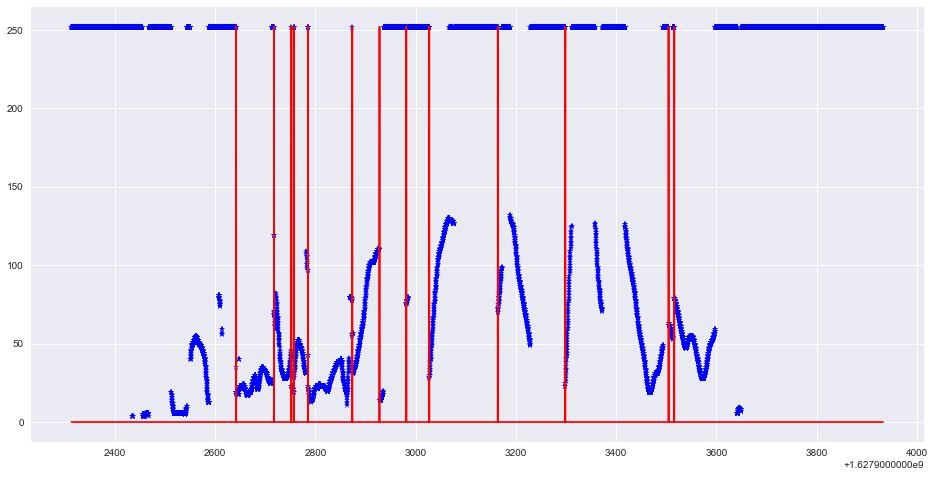

In [116]:
strymread.plt_ts(lead_distance_ts)


import matplotlib.pyplot as plt

def graph_see_events(lead, times, event_times):
    """
    TODO document this
    :param lead:
    :param times:
    :param event_times:
    :return:
    """
    def fake(time):
        if time in event_times:
            return 252
        else:
            return 0
    event_times_fake = [fake(time) for time in times]
    print(event_times_fake)
    print(sum(event_times_fake))
    # plt.figure()
    # plt.plot(times, lead, 'b*')
    # plt.plot(times, event_times_fake, 'r-')
    # plt.ion()
    # plt.show()
    fig, ax = plt.subplots()
    l = ax.plot(times, lead, 'b*')
    e = ax.plot(times, event_times_fake, 'r-')
    plt.ion()
    plt.show()
    # TODO make this interactive mode?

graph_see_events(lead_distance_ts['Message'], lead_distance_ts['Time'], event_times)


In [110]:
# TODO: find parameters lazy enough to try the correctness of the code
# TODO: loop over the files to do this analysis on all at once
# TODO: make something to see the curves + the event times selected on the same graph (fake curve ?)
# (+ also places with only some parts of the test succeeding?)

In [ ]:
for col in speed_ts.columns:
    print(col)
# strymread.plt_ts(speed_ts)
spd_messages = speed_ts['Message']
print(len(spd_messages))
print(spd_messages[80000])
# TODO DEBUG: speed is always at 0.0 within the code -> problematic
# -> probably because different lengths so stays i the first part where speed is 0
# -> find a way to resize like this
# -> index is not usable
# -> seems to have a different sampling frequency!
# TODO DEBUG -> sync speed and lead_distance? How to perform this?


#
spd_times = speed_ts['Time']
lead_times = lead_distance_ts['Time']
print(spd_times[0], spd_times[-1])
print(lead_times[0], lead_times[-1])
# -> not really aligned
# TODO DEBUG: find if that's only on this file or if these are really different everuytime
# then redo the scanning function to match with times
# (find a way to logically match times between different sampling frequencies) -> library for this exists?


In [112]:
# other analyses made up before



# print('\nspeed', speed_ts)
# print('\nlead_distance_ts', lead_distance_ts)
# print('\ncruise_control_state_ts', cruise_control_state_ts)
#
# strymread.plt_ts(lead_distance_ts)
# strymread.plt_ts(speed_ts)
# # lead distance? which unit? doesn't seem to really go below 10 that often... what to chose?




# # try to open the TS? they are pandas dataframes
# for col in lead_distance_ts.columns:
#     print(col)
# time = lead_distance_ts['Time']
# message = lead_distance_ts['Message']
# print(time[0], time[-1], len(time))



# Questions to ask:
- unit of lead_distance? feet, meters or something else
- same for speed -> seems to be in km/h though (max around 120)
- assumptions for previous_treshold and next_treshold?
- How to use the clock from the TS? freq echantillonage? -> le Clock thing isn't a column but doesn't seem standard
- why does different TS associated with the same event have different lengths? Is this different sampling frequencies?
- ask for sampling frequencies, things used to resolve those issues by the other members of CIRCLES?


# other personal work todo
- checkout strym tutorials: https://jmscslgroup.github.io/strym/
- checkout pandas tutorials: https://pandas.pydata.org/pandas-docs/stable/getting_started/index.html#getting-started
- strymread can only be used inside of jupiter notebooks......... okay to launch within docker containers????? check this out
- envoyer les messages sur CIRCLE pour avoir les réponses aux différents trucs
